In [2]:
import imblearn
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import getpass
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
password = getpass.getpass()

········


In [3]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = """select title, name as genre, release_year, MaxRentalDate, target as '1IfRentedInJune', NumberStars, NumberFilmRentedInJune, NumberFilmRentedBeforeJune, rating, rental_rate, NumberCopies
from (select count(film_id) NumberFilmRentedInJune ,film_id,  max(rental_date) as MaxRentalDate, 1 as target
from sakila.rental 
join sakila.inventory using(inventory_id) join sakila.film using(film_id)
where rental_date like '2005-06%%' 
group by film_id) sub right join (select count(inventory_id) as NumberCopies, film_id
from sakila.inventory i group by i.film_id) sub4 using(film_id)
right join sakila.film using(film_id)
left join (select count(actor_id) as NumberStars , film_id from sakila.film_actor 
group by film_id) sub2 using (film_id)
left join sakila.film_category using (film_id)
left join sakila.category using(category_id) left join (select count(film_id) as NumberFilmRentedBeforeJune, film_id from sakila.rental 
join sakila.inventory using(inventory_id)
where rental_date < '2005-06-01'
group by film_id) sub5 using(film_id)
;
"""


In [4]:
data = pd.read_sql_query(query, engine)
data

RuntimeError: 'cryptography' package is required for sha256_password or caching_sha2_password auth methods

In [5]:
data.isna().sum()#the number of distinct film_id in sakila.film is 1000 and in sakila.inventory
# only 958, this explains the 42 Nans for the 'NumberCopies' in the table

title                           0
genre                           0
release_year                    0
MaxRentalDate                 100
1IfRentedInJune               100
NumberStars                     3
NumberFilmRentedInJune        100
NumberFilmRentedBeforeJune    314
rating                          0
rental_rate                     0
NumberCopies                   42
dtype: int64

In [6]:
data['1IfRentedInJune']=data['1IfRentedInJune'].fillna('No')

In [7]:
data['1IfRentedInJune']=data['1IfRentedInJune'].replace([1.0], 'Yes')

In [8]:
data['RentedInJune?']=data['1IfRentedInJune']
data

,title,genre,release_year,MaxRentalDate,1IfRentedInJune,NumberStars,NumberFilmRentedInJune,NumberFilmRentedBeforeJune,rating,rental_rate,NumberCopies,RentedInJune?
0,ACADEMY DINOSAUR,Documentary,2006,2005-06-21 00:30:26,Yes,10.0,3.0,2.0,PG,0.99,8.0,Yes
1,ACE GOLDFINGER,Horror,2006,NaT,No,4.0,NaN,NaN,G,4.99,3.0,No
2,ADAPTATION HOLES,Documentary,2006,2005-06-15 18:17:28,Yes,5.0,1.0,1.0,NC-17,2.99,4.0,Yes
3,AFFAIR PREJUDICE,Horror,2006,2005-06-17 18:06:14,Yes,5.0,2.0,2.0,G,2.99,7.0,Yes
4,AFRICAN EGG,Family,2006,2005-06-18 05:21:12,Yes,5.0,2.0,1.0,G,2.99,3.0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...
995,YOUNG LANGUAGE,Documentary,2006,2005-06-19 01:34:26,Yes,5.0,1.0,NaN,G,0.99,2.0,Yes
996,YOUTH KICK,Music,2006,2005-06-21 06:24:45,Yes,5.0,1.0,NaN,NC-17,0.99,2.0,Yes
997,ZHIVAGO CORE,Horror,2006,2005-06-18 06:46:54,Yes,6.0,2.0,1.0,NC-17,0.99,2.0,Yes
998,ZOOLANDER FICTION,Children,2006,2005-06-19 19:18:09,Yes,5.0,2.0,1.0,R,2.99,5.0,Yes


In [9]:
data=data.drop(['1IfRentedInJune'], axis=1)

In [10]:
data0=data.drop(['MaxRentalDate','NumberFilmRentedInJune','rating'], axis=1) 

In [11]:
data0

,title,genre,release_year,NumberStars,NumberFilmRentedBeforeJune,rental_rate,NumberCopies,RentedInJune?
0,ACADEMY DINOSAUR,Documentary,2006,10.0,2.0,0.99,8.0,Yes
1,ACE GOLDFINGER,Horror,2006,4.0,NaN,4.99,3.0,No
2,ADAPTATION HOLES,Documentary,2006,5.0,1.0,2.99,4.0,Yes
3,AFFAIR PREJUDICE,Horror,2006,5.0,2.0,2.99,7.0,Yes
4,AFRICAN EGG,Family,2006,5.0,1.0,2.99,3.0,Yes
...,...,...,...,...,...,...,...,...
995,YOUNG LANGUAGE,Documentary,2006,5.0,NaN,0.99,2.0,Yes
996,YOUTH KICK,Music,2006,5.0,NaN,0.99,2.0,Yes
997,ZHIVAGO CORE,Horror,2006,6.0,1.0,0.99,2.0,Yes
998,ZOOLANDER FICTION,Children,2006,5.0,1.0,2.99,5.0,Yes


In [12]:
data0=data0.set_index('title')

In [13]:
data0

,genre,release_year,NumberStars,NumberFilmRentedBeforeJune,rental_rate,NumberCopies,RentedInJune?
title,,,,,,,
ACADEMY DINOSAUR,Documentary,2006,10.0,2.0,0.99,8.0,Yes
ACE GOLDFINGER,Horror,2006,4.0,NaN,4.99,3.0,No
ADAPTATION HOLES,Documentary,2006,5.0,1.0,2.99,4.0,Yes
AFFAIR PREJUDICE,Horror,2006,5.0,2.0,2.99,7.0,Yes
AFRICAN EGG,Family,2006,5.0,1.0,2.99,3.0,Yes
...,...,...,...,...,...,...,...
YOUNG LANGUAGE,Documentary,2006,5.0,NaN,0.99,2.0,Yes
YOUTH KICK,Music,2006,5.0,NaN,0.99,2.0,Yes
ZHIVAGO CORE,Horror,2006,6.0,1.0,0.99,2.0,Yes


In [14]:
data0.dtypes

genre                          object
release_year                    int64
NumberStars                   float64
NumberFilmRentedBeforeJune    float64
rental_rate                   float64
NumberCopies                  float64
RentedInJune?                  object
dtype: object

In [15]:
data0.isna().sum()

genre                           0
release_year                    0
NumberStars                     3
NumberFilmRentedBeforeJune    314
rental_rate                     0
NumberCopies                   42
RentedInJune?                   0
dtype: int64

In [16]:
data0['NumberStars']=data0['NumberStars'].fillna(data0['NumberStars'].mean())


In [17]:
data0['NumberFilmRentedBeforeJune'].unique()

array([ 2., nan,  1.,  3.,  4.,  5.])

In [18]:
data0['NumberFilmRentedBeforeJune']=data0['NumberFilmRentedBeforeJune'].fillna(0) 
#nans in this column must mean, that films were not rented before June

In [19]:
data0['NumberCopies']=data0['NumberCopies'].fillna(1) #decided to rather take a low number
#of copies for the nans then a higher average number. A lower number seems to me more reasonable
#since those films are not in the inventory table listed. Also thinking about replacing them even
#with a 0.



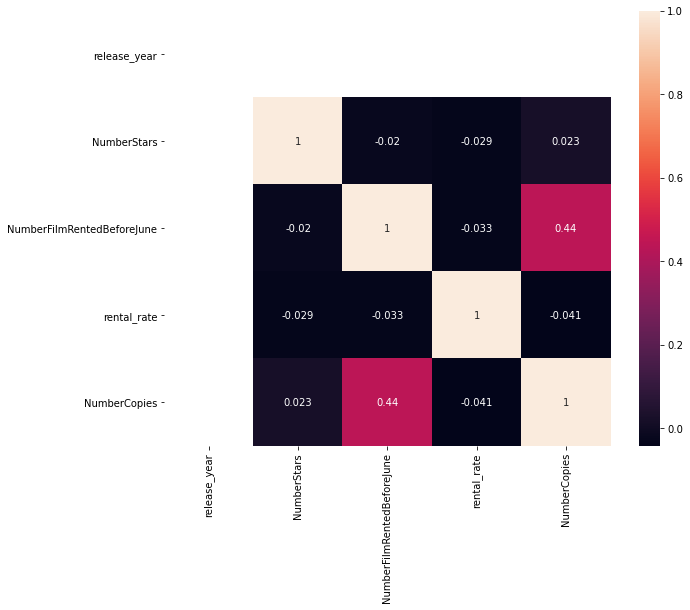

In [20]:
corr_matrix=data0.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

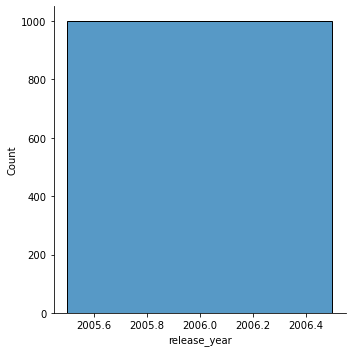

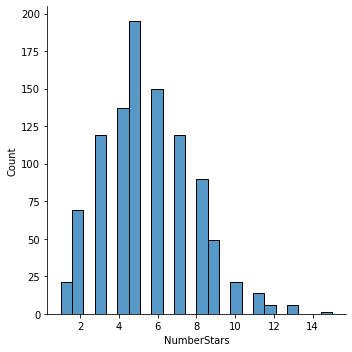

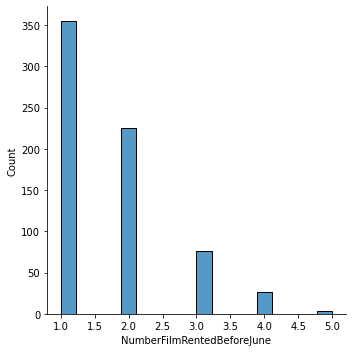

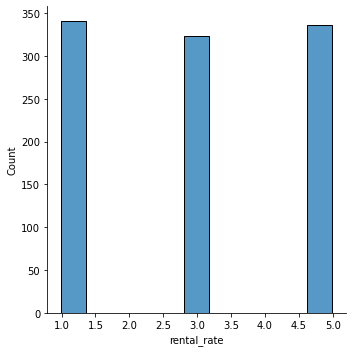

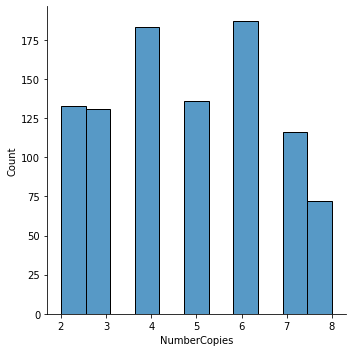

In [21]:
for col in data0.select_dtypes(np.number):
    sns.displot(data[col])
    plt.show()

In [22]:
y = data0['RentedInJune?']
X = data0.drop('RentedInJune?', axis=1)

In [23]:
X=pd.get_dummies(X, prefix=['genre'], columns=['genre'])

In [24]:
X

,release_year,NumberStars,NumberFilmRentedBeforeJune,rental_rate,NumberCopies,genre_Action,genre_Animation,genre_Children,genre_Classics,genre_Comedy,...,genre_Drama,genre_Family,genre_Foreign,genre_Games,genre_Horror,genre_Music,genre_New,genre_Sci-Fi,genre_Sports,genre_Travel
title,,,,,,,,,,,,,,,,,,,,,
ACADEMY DINOSAUR,2006,10.0,2.0,0.99,8.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACE GOLDFINGER,2006,4.0,0.0,4.99,3.0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
ADAPTATION HOLES,2006,5.0,1.0,2.99,4.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AFFAIR PREJUDICE,2006,5.0,2.0,2.99,7.0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
AFRICAN EGG,2006,5.0,1.0,2.99,3.0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YOUNG LANGUAGE,2006,5.0,0.0,0.99,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
YOUTH KICK,2006,5.0,0.0,0.99,2.0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
ZHIVAGO CORE,2006,6.0,1.0,0.99,2.0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [25]:
data0['NumberFilmRentedBeforeJune'].unique() #really only 5 the biggest number? A little strange ...
# but probabely true, because there has only been the month may before june in the dataset

array([2., 0., 1., 3., 4., 5.])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
classification = LogisticRegression(random_state=42, max_iter=10000)
classification.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [28]:
classification.score(X_test, y_test)

0.905

In [29]:
predictions = classification.predict(X_test)

pd.Series(predictions).value_counts()

Yes    178
No      22
dtype: int64

In [30]:
confusion_matrix(y_test, predictions)

array([[ 13,  10],
       [  9, 168]])

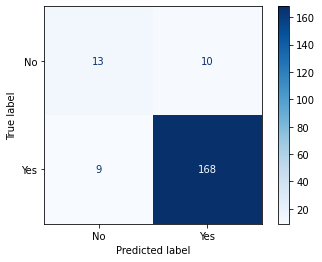

In [31]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(classification, X_test, y_test, cmap='Blues')
plt.show()

In [32]:
from sklearn.metrics import classification_report
classification_report(y_test, predictions) 

'              precision    recall  f1-score   support\n\n          No       0.59      0.57      0.58        23\n         Yes       0.94      0.95      0.95       177\n\n    accuracy                           0.91       200\n   macro avg       0.77      0.76      0.76       200\nweighted avg       0.90      0.91      0.90       200\n'

In [33]:
#recall yes: 95%, recall No: 57%
#it would probabely do improvements to the prediction, if the data for No's in the target 
#would get an upsampling, because there is only a little number of No's in the dataset (imbalance)

In [34]:
correlations=pd.get_dummies(data0['RentedInJune?']).corrwith(data0['NumberStars'])
correlations

No    -0.014161
Yes    0.014161
dtype: float64

In [35]:
correlations2=pd.get_dummies(data0['RentedInJune?']).corrwith(data0['rental_rate'])
correlations2

No     0.034436
Yes   -0.034436
dtype: float64

In [36]:
correlations3=pd.get_dummies(data0['RentedInJune?']).corrwith(data0['NumberCopies'])
correlations3

No    -0.418033
Yes    0.418033
dtype: float64

In [37]:
correlations4=pd.get_dummies(data0['RentedInJune?']).corrwith(data0['NumberFilmRentedBeforeJune'])
correlations4

No    -0.365798
Yes    0.365798
dtype: float64